In [1]:
import sys
import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine
import pandas as pd

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [2]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

In [3]:
g = nx.read_gpickle('full690k.gpickle')
len(g.nodes())

10346

In [4]:
import pandas as pd
import glob

path = r'../eco_files/' # use your path
all_files = glob.glob(path + "/*.tsv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep = '\t')
    li.append(df)

eco_df = pd.concat(li, axis=0, ignore_index=True)

In [5]:
print(eco_df.shape)
eco_df.head()

(3402, 4)


,eco,name,fen,moves
0,E00,Catalan Opening: Hungarian Gambit,rnbqkb1r/pppp1ppp/5n2/4p3/2PP4/6P1/PP2PP1P/RNB...,d2d4 g8f6 c2c4 e7e6 g2g3 e6e5
1,E00,Catalan Opening,rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/6P1/PP2PP1P/RNB...,d2d4 g8f6 c2c4 e7e6 g2g3 d7d5
2,E00,Catalan Opening,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/6P1/PP2PP1P/RNBQ...,d2d4 g8f6 c2c4 e7e6 g2g3
3,E00,Indian Game: Devin Gambit,rnbqkb1r/pppp1ppp/4pn2/8/2PP2P1/8/PP2PP1P/RNBQ...,d2d4 g8f6 c2c4 e7e6 g2g4
4,E00,Indian Game,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/1Q6/PP2PPPP/RNB1...,d2d4 g8f6 c2c4 e7e6 d1b3


In [6]:
eco_list = list(eco_df['fen'])
sd_list = []
node_fen = list(g.nodes())
for eco in eco_list:
    currFen = [fen for fen in node_fen if eco in fen]
    if(len(currFen)>0):
        currFen = str(currFen[0])
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(currFen)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
        sd_list.append(np.sqrt(varWeighted(scores,counts)))
#         print('{} {} ||| SD :'.format(key, game), np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))
    except:
        sd_list.append(None)

In [7]:
sd_list[:10]

[None, None, None, None, None, None, None, None, None, None]

In [8]:
eco_df['sd'] = sd_list

In [19]:
eco_df.sort_values(by = ['sd'], ascending = False)

,eco,name,fen,moves,sd,move_count
982,C20,King's Pawn Game: Wayward Queen Attack,rnbqkbnr/pppp1ppp/8/4p2Q/4P3/8/PPPP1PPP/RNB1KB...,e2e4 e7e5 d1h5,3890.540970,14
332,D00,Queen's Pawn Game: Levitsky Attack,rnbqkbnr/ppp1pppp/8/3p2B1/3P4/8/PPP1PPPP/RN1QK...,d2d4 d7d5 c1g5,458.059378,14
1703,C57,"Italian Game: Two Knights Defense, Knight Attack",r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP...,e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 f3g5,375.557530,34
1698,C57,"Italian Game: Two Knights Defense, Fried Liver...",r1bqkb1r/ppp2Npp/2n5/3np3/2B5/8/PPPP1PPP/RNBQK...,e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 f3g5 d7d5 e4d5 f...,336.582828,54
1015,C22,Center Game: Normal Variation,r1bqkbnr/pppp1ppp/2n5/8/3QP3/8/PPP2PPP/RNB1KBN...,e2e4 e7e5 d2d4 e5d4 d1d4 b8c6,328.208346,29
...,...,...,...,...,...,...
3397,A96,Dutch Defense: Classical Variation,rnbq1rk1/ppp1b1pp/3ppn2/5p2/2PP4/5NP1/PP2PPBP/...,d2d4 e7e6 c2c4 f7f5 g2g3 g8f6 f1g2 f8e7 g1f3 e...,NaN,59
3398,A97,"Dutch Defense: Classical Variation, Ilyin-Zhen...",rnb1qrk1/ppp1b1pp/3ppn2/5p2/2PP4/2N2NP1/PP2PPB...,d2d4 f7f5 g1f3 g8f6 g2g3 e7e6 f1g2 f8e7 e1g1 e...,NaN,69
3399,A97,"Dutch Defense: Ilyin-Zhenevsky, Winter Variation",rnb1qrk1/ppp1b1pp/3ppn2/5p2/2PP4/2N2NP1/PP2PPB...,d2d4 f7f5 g1f3 g8f6 g2g3 e7e6 f1g2 f8e7 e1g1 e...,NaN,74
3400,A98,"Dutch Defense: Classical Variation, Ilyin-Zhen...",rnb1qrk1/ppp1b1pp/3ppn2/5p2/2PP4/2N2NP1/PPQ1PP...,d2d4 f7f5 g1f3 g8f6 g2g3 e7e6 f1g2 f8e7 e1g1 e...,NaN,74


In [28]:
eco_df['move_count'] = eco_df['moves'].apply(lambda x: len(x.split()))

In [29]:
eco_df.head()

,eco,name,fen,moves,sd,move_count
0,E00,Catalan Opening: Hungarian Gambit,rnbqkb1r/pppp1ppp/5n2/4p3/2PP4/6P1/PP2PP1P/RNB...,d2d4 g8f6 c2c4 e7e6 g2g3 e6e5,NaN,6
1,E00,Catalan Opening,rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/6P1/PP2PP1P/RNB...,d2d4 g8f6 c2c4 e7e6 g2g3 d7d5,NaN,6
2,E00,Catalan Opening,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/6P1/PP2PP1P/RNBQ...,d2d4 g8f6 c2c4 e7e6 g2g3,NaN,5
3,E00,Indian Game: Devin Gambit,rnbqkb1r/pppp1ppp/4pn2/8/2PP2P1/8/PP2PP1P/RNBQ...,d2d4 g8f6 c2c4 e7e6 g2g4,NaN,5
4,E00,Indian Game,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/1Q6/PP2PPPP/RNB1...,d2d4 g8f6 c2c4 e7e6 d1b3,NaN,5


(0, 500)

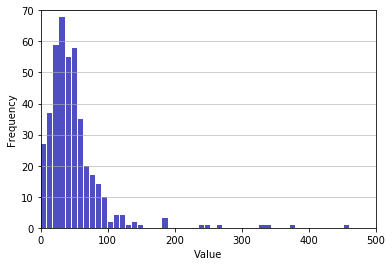

In [15]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=eco_df['sd'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = 0, xmax = 500)

(0, 15)

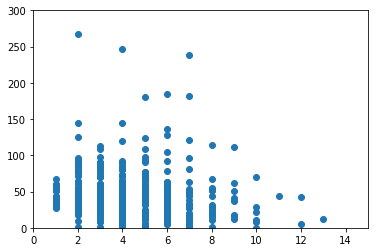

In [33]:
plt.scatter(eco_df['move_count'], eco_df['sd'])
plt.ylim(0,300)
plt.xlim(0,15)

In [35]:
eco_df['move_count'].corr(eco_df['sd'])

-0.03374379837242805